In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# Resample
from imblearn import over_sampling

# ML
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, Conv1D, MaxPool1D, Dense, Dropout, Bidirectional, TextVectorization

In [86]:
# Function to verify training history
def plot_history(history: list):
    
    legend = ['Train', 'Validation']
    
    key_list = list(history.history.keys())
    plt.figure(figsize=(6,3*int((len(key_list))/2)))
    for val, metric in enumerate(key_list[0:int((len(key_list))/2)]):
        plt.subplot(int((len(key_list))/2), 1, val+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+ metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend(legend, loc='best')

In [87]:
airline_review = pd.read_csv('Airline-Sentiment_processed.csv')
airline_review

,airline_sentiment,airline,text,text_preprocessed
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,what said
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,plus you have added commercials to the experie...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,i did not today must mean i need to take anoth...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,it is really aggressive to blast obnoxious ent...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,and it is a really big bad thing about it
...,...,...,...,...
14635,positive,American,@AmericanAir thank you we got on a different f...,thank you we got on a different flight to chicago
14636,negative,American,@AmericanAir leaving over 20 minutes Late Flig...,leaving over 20 minutes late flight no warning...
14637,neutral,American,@AmericanAir Please bring American Airlines to...,please bring american airlines to
14638,negative,American,"@AmericanAir you have my money, you change my ...",you have my money you change my flight and do ...


<p>Before proceeding we will check the max length of a sentence, to define the overall length of our vectors</p>

In [88]:
max_ = 0
for tweets in airline_review['text_preprocessed']:
    if len(tweets.split()) > max_:
        max_ = len(tweets)

In [89]:
max_


53

<h2>We have seen that the data is imbalanced, but at this stage let's forget that and make it a working notebook and we'll address that "issue" later and see if with resampling we can improve the results</h2>

<h3>Split into training data and validation data</h3>

In [90]:
training_portion = 0.8
airline_review = shuffle(airline_review)
airline_review = shuffle(airline_review)

train_size = int(airline_review.shape[0] * training_portion)
print("Train size: {}".format(train_size))
x_train, x_val, y_train, y_val = train_test_split(airline_review['text_preprocessed'], airline_review['airline_sentiment'],
                                                 train_size=0.8,random_state=123)

print("Train text size: {}".format(x_train.shape))
print("Train Sentiment size: {}".format(y_train.shape))
print('-------------//---------------')
print("Valid text size: {}".format(x_val.shape))
print("Valid Sentiment size: {}".format(y_val.shape))


Train size: 11712
Train text size: (11712,)
Train Sentiment size: (11712,)
-------------//---------------
Valid text size: (2928,)
Valid Sentiment size: (2928,)


In [91]:
vocab_size = 20000
embedding_dim = 64
max_length = max_ + 10
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

<h3>Tokenization of our dataset</h3>

In [92]:
tokenizer = Tokenizer(num_words=20000, # it will only consider the 20000 most common words
                      oov_token=oov_tok) # oov_token is to put a special value in when an unseen word is encountered

tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

<h3>Tweets to sequences.</h3>

In [93]:
x_train_sequences = tokenizer.texts_to_sequences(x_train)
#x_train_sequences

<h3>Pad sequences. Make all sentences the same length</h3>

In [103]:
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type,
                              )

In [104]:
x_val_sequences = tokenizer.texts_to_sequences(x_val)
x_val_padded = pad_sequences(x_val_sequences, maxlen=max_length,
                            padding=padding_type, truncating=trunc_type)

In [105]:
x_train_padded.shape, x_val_padded.shape

((11712, 63), (2928, 63))

<h3>Token our target</h3>


In [106]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)

y_train_ = np.array(label_tokenizer.texts_to_sequences(y_train)) - 1
y_val_ = np.array(label_tokenizer.texts_to_sequences(y_val)) - 1

In [107]:
y_train_.min(), y_train_.max()

(0, 2)

<h3>Model Definition with "our" Embedding Matrix</h3>

In [108]:
# define model

model = Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    keras.layers.Dropout(0.4),
    keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 64)          1280000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,354,499
Trainable params: 1,354,499
Non-trainable params: 0
____________________________________________

In [109]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(x_train_padded,
                    y_train_,
                    epochs=num_epochs,
                    validation_data=(x_val_padded, y_val_),
                    verbose=1)

Epoch 1/10
366/366 [==============================] - 27s 64ms/step - loss: 0.6794 - accuracy: 0.7147 - val_loss: 0.5335 - val_accuracy: 0.7941
Epoch 2/10
366/366 [==============================] - 22s 60ms/step - loss: 0.4317 - accuracy: 0.8394 - val_loss: 0.5285 - val_accuracy: 0.7961
Epoch 3/10
366/366 [==============================] - 22s 61ms/step - loss: 0.3102 - accuracy: 0.8870 - val_loss: 0.5767 - val_accuracy: 0.7906
Epoch 4/10
366/366 [==============================] - 20s 56ms/step - loss: 0.2368 - accuracy: 0.9182 - val_loss: 0.6632 - val_accuracy: 0.7906
Epoch 5/10
366/366 [==============================] - 21s 57ms/step - loss: 0.1890 - accuracy: 0.9356 - val_loss: 0.7035 - val_accuracy: 0.7725
Epoch 6/10
366/366 [==============================] - 22s 60ms/step - loss: 0.1480 - accuracy: 0.9507 - val_loss: 0.8071 - val_accuracy: 0.7582
Epoch 7/10
366/366 [==============================] - 21s 56ms/step - loss: 0.1224 - accuracy: 0.9582 - val_loss: 0.8967 - val_accuracy:

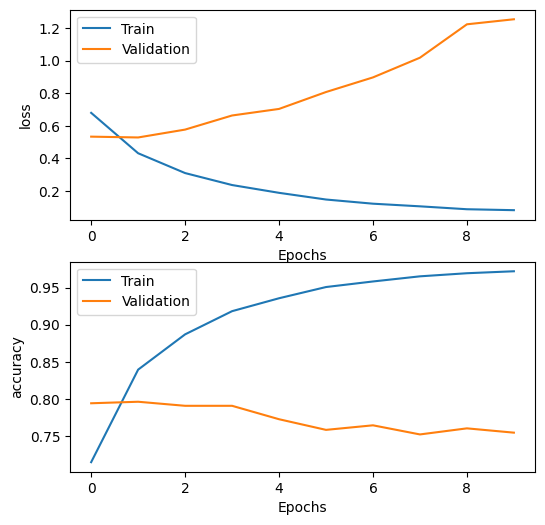

In [110]:
plot_history(history)

<h3>Model definition with pretrained word embedding</h3>

In [119]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/home/salvado/Documents/TensorFlow/glove/glove.6B.200d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


<p>At this point we are going to prepare the embedding matrix to be used as our first layer of our model</p>
<p>First Step: TextVectorization.</p>

In [120]:
vectorizer = TextVectorization(max_tokens=20000,output_sequence_length=max_length,)

vectorizer.adapt(x_train)
vocabulary = vectorizer.get_vocabulary()
len(vocabulary)

10516

In [115]:
# create a word_index dictionary
word_index = dict(zip(vocabulary, range(len(vocabulary))))

In [118]:
# matrix embedding preparation
num_tokens = len(vocabulary) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8913 words (1603 misses)


<p>At this point we have our embedding matrix created</p>

In [126]:
# train the model

x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()

In [122]:
# let's load the pretrained word embeddings matrix into the Embedding layer
embedding_layer = Embedding(input_dim=num_tokens,
                            output_dim=embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=False
                           )

In [130]:
# define model

model = Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    #keras.layers.Embedding(vocab_size, embedding_dim),
    embedding_layer,
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    keras.layers.Dense(embedding_dim, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(embedding_dim, activation='relu'),
    keras.layers.Dropout(0.3),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    #keras.layers.Dropout(0.4),
    keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         1051800   
                                                                 
 bidirectional_9 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 100)               10100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                      

In [131]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(x_train,
                    y_train_,
                    epochs=num_epochs,
                    validation_data=(x_val, y_val_),
                    verbose=1)

Epoch 1/10
366/366 [==============================] - 28s 69ms/step - loss: 0.7019 - accuracy: 0.7166 - val_loss: 0.6132 - val_accuracy: 0.7534
Epoch 2/10
366/366 [==============================] - 24s 67ms/step - loss: 0.5743 - accuracy: 0.7705 - val_loss: 0.5793 - val_accuracy: 0.7661
Epoch 3/10
366/366 [==============================] - 24s 66ms/step - loss: 0.5345 - accuracy: 0.7911 - val_loss: 0.5768 - val_accuracy: 0.7708
Epoch 4/10
366/366 [==============================] - 24s 66ms/step - loss: 0.5043 - accuracy: 0.7970 - val_loss: 0.5466 - val_accuracy: 0.7838
Epoch 5/10
366/366 [==============================] - 24s 67ms/step - loss: 0.4728 - accuracy: 0.8163 - val_loss: 0.5413 - val_accuracy: 0.7852
Epoch 6/10
366/366 [==============================] - 24s 67ms/step - loss: 0.4366 - accuracy: 0.8270 - val_loss: 0.5667 - val_accuracy: 0.7753
Epoch 7/10
366/366 [==============================] - 24s 67ms/step - loss: 0.4113 - accuracy: 0.8375 - val_loss: 0.5682 - val_accuracy: